# <center>__Assignment 3__</center>

In [1]:
"""load the necessary packages"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

## *Part 1: Data Exploration*

Objectives

- Load the Titanic dataset from Seaborn
- Document missing data numerically (count missing values) and visually (heatmap)
- Document data types for each feature
- Explore the data
    - Did more women or men die?
    - Which passenger class was more likely to survive?
    - Explore the distribution of fares
    - Explore the distribution of non-null age values
    - What is the median age of each passenger class?
    - Visualize age in each passenger class using a boxplot

In [2]:
"""load the data from Github"""
! curl https://raw.githubusercontent.com/arjayit/cs4432_data/master/train.csv --output titanic.csv
titanic = pd.read_csv('titanic.csv')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 61194  100 61194    0     0   204k      0 --:--:-- --:--:-- --:--:--  207k


In [3]:
"""document missing data numerically"""

# display count
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
"""document missing data numerically"""

# display ratio
titanic.isnull().sum()/titanic.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

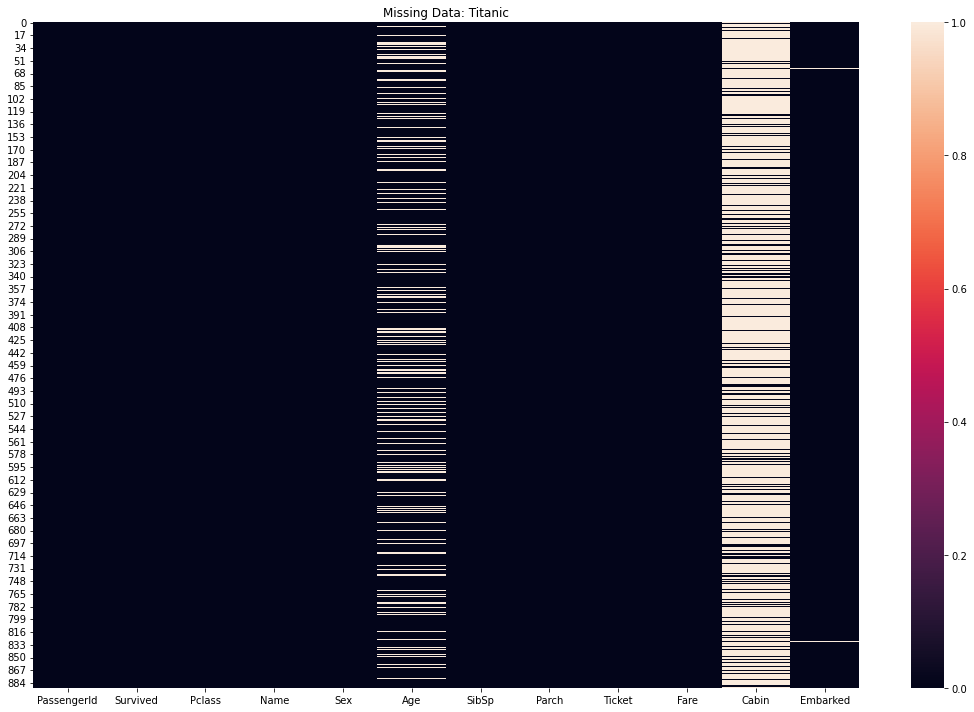

In [5]:
"""document missing data visually"""

# seabornn heatmap of missing values
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(titanic.isnull())
plt.title('Missing Data: Titanic')
plt.tight_layout()

In [6]:
"""document data types for each feature"""

titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
"""did more women or men die (numeric exploration)"""

titanic[['Survived', 'Sex']].groupby(by=['Sex'], dropna=True)['Survived'].value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

Text(0.5, 1.0, 'Survival by Sex (0=Perished, 1=Survived)')

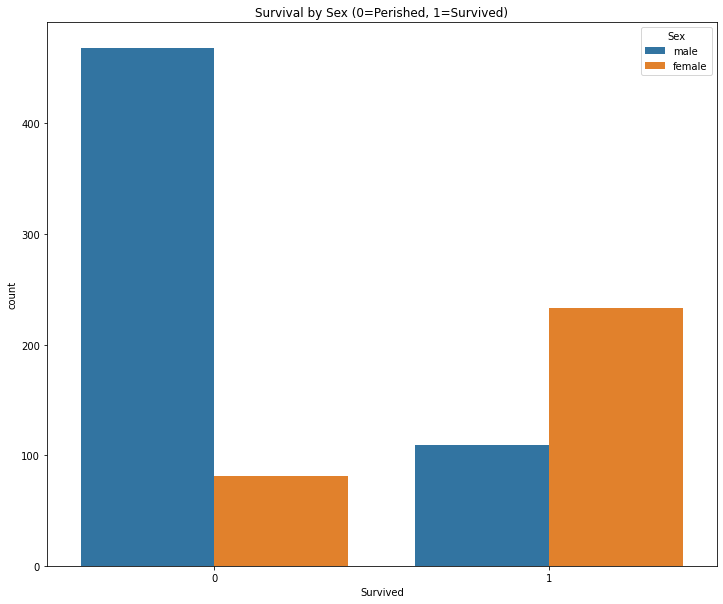

In [8]:
"""did more women or men die visual exploration"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=titanic, x='Survived', hue='Sex')
plt.title('Survival by Sex (0=Perished, 1=Survived)')

In [9]:
"""liklehood of survival by class (numeric exploration)"""

titanic[['Survived', 'Pclass']].groupby(by=['Pclass'],
                                       dropna=True)\
                                       ['Survived'].value_counts(normalize=True)

Pclass  Survived
1       1           0.629630
        0           0.370370
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64

Text(0.5, 1.0, 'Survival by Boarding Class (0=Perished, 1=Survived)')

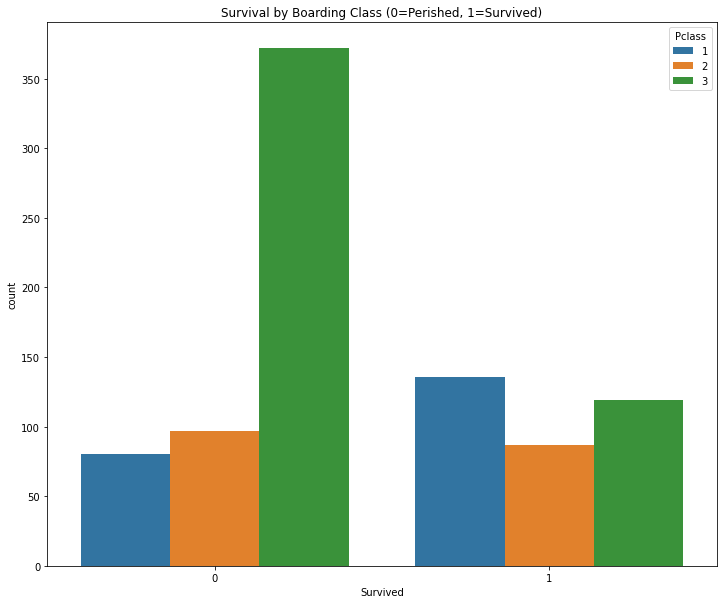

In [10]:
"""likelihood of survival by class visual exploration"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=titanic, x='Survived', hue='Pclass')
plt.title('Survival by Boarding Class (0=Perished, 1=Survived)')

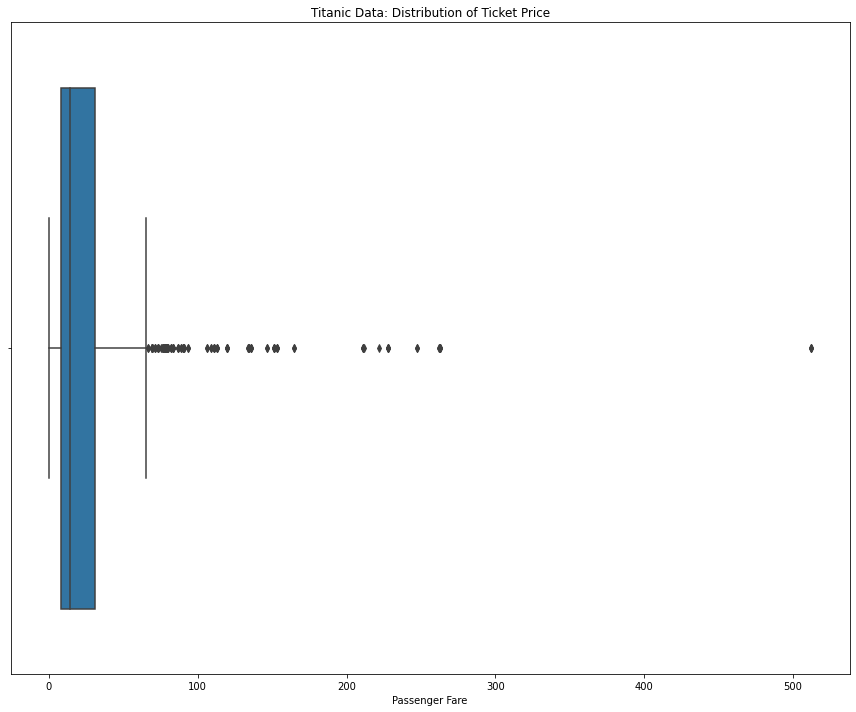

In [11]:
"""plot the distribution of ticket price (boxplot)"""

fig, axs = plt.subplots(figsize=(12, 10))
sns.boxplot(data=titanic, x="Fare")
plt.xlabel('Passenger Fare')
plt.title('Titanic Data: Distribution of Ticket Price')
plt.tight_layout()

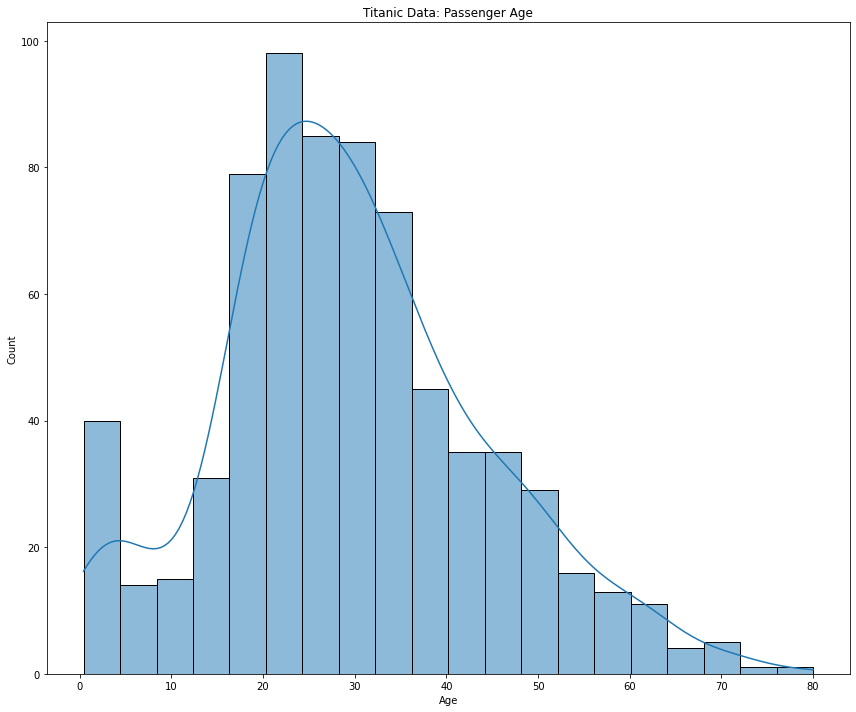

In [12]:
"""plot the distribution of age"""
fig, ax = plt.subplots(figsize=(12, 10))
sns.histplot(data=titanic, x='Age', kde=True)
plt.title('Titanic Data: Passenger Age')
plt.tight_layout()

In [13]:
"""print the median age of each passenger class"""

median_vals = titanic[['Age', 'Pclass']].groupby(by=['Pclass']).median()
median_vals

,Age
Pclass,
1,37.0
2,29.0
3,24.0


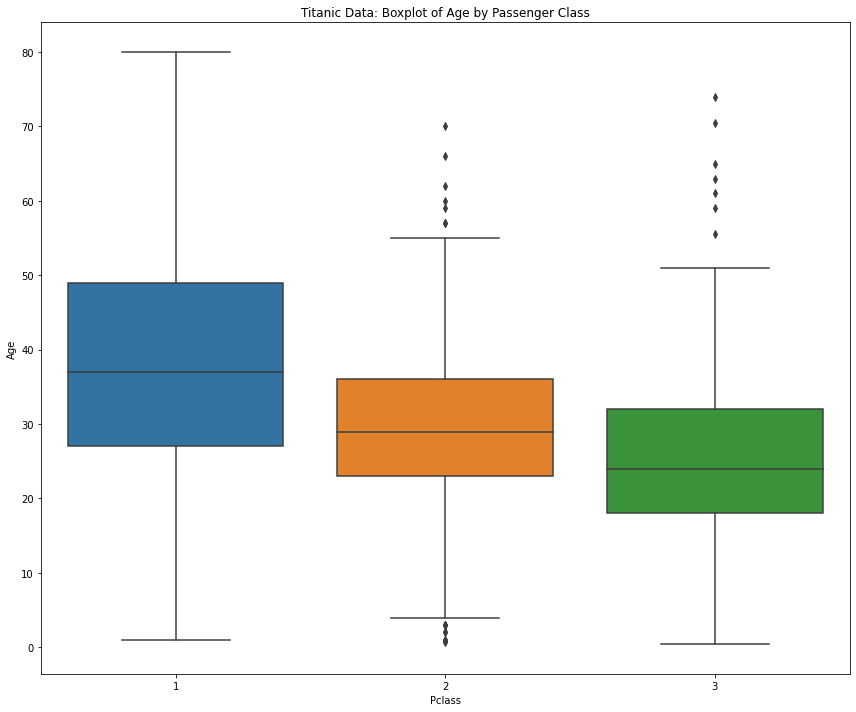

In [14]:
"""boxplot of age by passenger class"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.boxplot(data=titanic, x='Pclass', y='Age')
plt.title('Titanic Data: Boxplot of Age by Passenger Class')
plt.tight_layout()

## *Part 2: Data Cleansing*

Objectives

- Drop the "cabin" feature from the dataset
- Impute missing values in the age feature using median age value of a passengers respective boarding class
- Drop all remaining records with null values
- Ensure all null values have been removed
- Convert categorical values to dummies using pd.get_dummies() function
- Drop the "name", "ticket", and "passengerid" features
- Copy contents of the "survived" feature vecture to a new dataframe, this is the target label
- split the data into training and test sets

In [15]:
"""drop the cabin feature from the titanic dataframe"""

titanic.drop(columns=['Cabin'], inplace=True)

In [16]:
"""
Impute missing values in the age feature using median age value of a passengers
respective boarding class. Boolean index used instead of pd.apply, faster and easier syntax
"""

titanic.loc[(titanic['Pclass'] == 1) & (titanic['Age'].isna()), 'Age'] = median_vals['Age'][1]
titanic.loc[(titanic['Pclass'] == 2) & (titanic['Age'].isna()), 'Age'] = median_vals['Age'][2]
titanic.loc[(titanic['Pclass'] == 3) & (titanic['Age'].isna()), 'Age'] = median_vals['Age'][3]
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       2
dtype: int64

In [17]:
"""drop remaining rows with missing values"""

titanic.dropna(axis=0,  inplace=True)
titanic.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [18]:
"""
Drop features name, ticket, and passengerid
get dummies for remaining categorical features then drop origina columns
"""

titanic.drop(columns=['Name', 'Ticket', 'PassengerId'], inplace=True)
categorical_idx = titanic.select_dtypes(exclude=['int64', 'float64']).columns
dummy_vars = pd.get_dummies(titanic[categorical_idx])
titanic = pd.concat([titanic, dummy_vars], axis=1)
titanic.drop(columns=categorical_idx, inplace=True)


In [19]:
"""
create the feature set by copying target label to new dataframe and dropping from features
split data into traning and test sets
"""
y = titanic['Survived'].copy()
titanic.drop(columns=['Survived'], inplace=True)
X_train, X_test, y_train, y_test = train_test_split(titanic, y,test_size=.30,
                                                    random_state=14)

## *Part 3: Model Tuning*

Objectives

- Implement a logisitc regression model
- Implement a support vector classifier
- implement a sgd classifier
- Print classifcation reports for each model
- Print confusion matrices for each model
- Print ROC score and and chart for each model

In [20]:
"""implement a simple logisitic regression model with cross validation"""

lrm = LogisticRegression(max_iter=500)
lrm.fit(X_train, y_train)
train_predicted = cross_val_predict(lrm, X_train, y_train, cv=3)

In [21]:
"""print classification report for the logiistic regression model"""

print(classification_report(y_train, train_predicted))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83       384
           1       0.75      0.67      0.71       238

    accuracy                           0.79       622
   macro avg       0.78      0.76      0.77       622
weighted avg       0.78      0.79      0.78       622



In [22]:
"""print confusion matrix for logistic regression model"""

confusion_matrix(y_train, train_predicted)

array([[330,  54],
       [ 79, 159]])

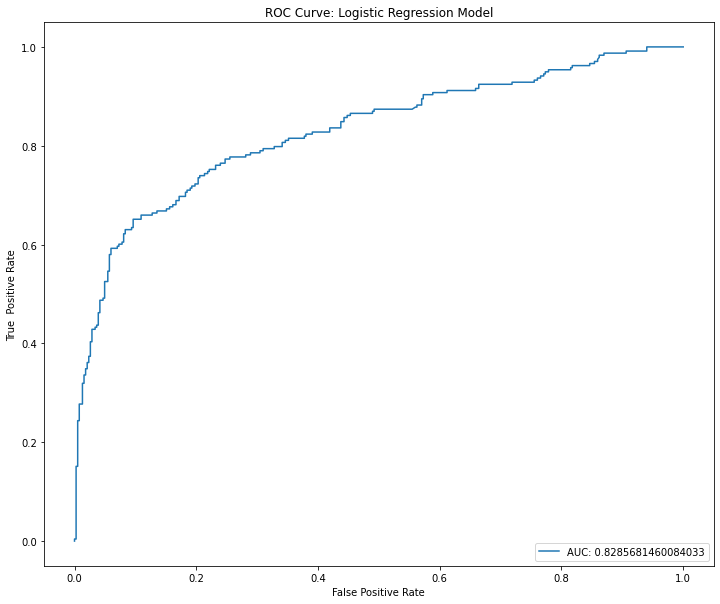

In [23]:
"""plot receiver operating characteristic for logistic regression model(score included in plot)"""

predicted_probs = cross_val_predict(lrm, X_train, y_train, cv=3, method='predict_proba')
probs_array = predicted_probs[::, 1]
fpr, tpr, thresholds = roc_curve(y_train, probs_array)
auc = roc_auc_score(y_train, probs_array)
plt.subplots(figsize=(12, 10))
plt.title('ROC Curve: Logistic Regression Model')
plt.plot(fpr, tpr, label='AUC: '+str(auc))
plt.ylabel('True  Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [24]:
"""
implement a simple support vector classifier with rbf kernel
"""

svc = SVC(kernel='rbf', gamma='auto', C=1, probability=True)
svc.fit(X_train, y_train)
#train_predicted = cross_val_predict(svc, X_train, y_train, cv=3, method='decision_function')
train_predicted = cross_val_predict(svc, X_train, y_train, cv=3)

In [25]:
"""print classification report for support vector classifier"""

print(classification_report(y_train, train_predicted))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       384
           1       0.64      0.49      0.55       238

    accuracy                           0.70       622
   macro avg       0.68      0.66      0.66       622
weighted avg       0.69      0.70      0.69       622



In [26]:
"""print confusion matrix for support vector classifier"""

confusion_matrix(y_train, train_predicted)

array([[318,  66],
       [122, 116]])

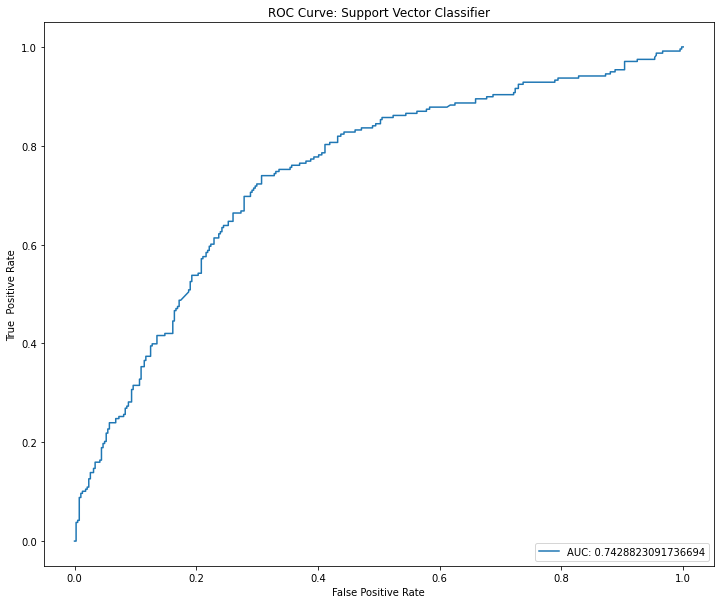

In [27]:
"""print/plot receiver operating characteristic for support vector classifier model(score included in plot)"""

predicted_probs = cross_val_predict(svc, X_train, y_train, cv=3, method='predict_proba')
probs_array = predicted_probs[::, 1]
fpr, tpr, thresholds = roc_curve(y_train, probs_array)
auc = roc_auc_score(y_train, probs_array)
plt.subplots(figsize=(12, 10))
plt.plot(fpr, tpr, label='AUC: '+str(auc))
plt.title('ROC Curve: Support Vector Classifier')
plt.ylabel('True  Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)

plt.show()

In [28]:
"""implement a simple stochastic gradient descent model"""

sgd = SGDClassifier(max_iter=1000, early_stopping=True, random_state=14, penalty='elasticnet')
sgd.fit(X_train, y_train)
train_predicted = cross_val_predict(sgd, X_train, y_train, cv=3)

In [29]:
"""print classification report for stochastic gradient descent model"""

print(classification_report(y_train, train_predicted))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62       384
           1       0.46      0.63      0.54       238

    accuracy                           0.58       622
   macro avg       0.59      0.59      0.58       622
weighted avg       0.61      0.58      0.59       622



In [30]:
"""print confusion matrix for stochastic gradient descent model"""

confusion_matrix(y_train, train_predicted)

array([[210, 174],
       [ 87, 151]])

## *Part 4*

Objectives

- Implement an sklearn pipeline to scale input features and instantiate a support vector classifier
- Perform a grid search with parameters specified in the assignment instructions using the support vector classification model pipeline
- Print the best estimator, its parameters, and the resulting score
- Apply the best estimator to the test set
- Implement a learning curve using the best estimator. Apply graph styling specified in the assignment instructions

In [31]:
"""Implement an sklearn pipeline to scale input features and instantiate a 
support vector classifier
"""

svc_pipeline = Pipeline([('scaler', StandardScaler()), ('svc',SVC())])
svc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())])

In [32]:
"""Perform a grid search with parameters specified in the assignment instructions using 
the support vector classification model pipeline
"""

params = {'svc__kernel': ['rbf'], 'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1], 'svc__C': [1, 10, 50, 100, 200, 300]}
grid_search = GridSearchCV(svc_pipeline, params)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [1, 10, 50, 100, 200, 300],
                         'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1],
                         'svc__kernel': ['rbf']})

In [33]:
"""Print the best estimator, its parameters, and the resulting score"""

print(grid_search.best_estimator_)
print()
print(grid_search.best_params_)
print()
print("The best score obtained using grid search was {}".format(grid_search.best_score_))

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=200, gamma=0.1))])

{'svc__C': 200, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}

The best score obtained using grid search was 0.808683870967742


In [34]:
"""make predictions on the test set using best estimator"""

from sklearn.metrics import accuracy_score


predicted = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       165
           1       0.72      0.61      0.66       102

    accuracy                           0.76       267
   macro avg       0.75      0.73      0.74       267
weighted avg       0.76      0.76      0.76       267



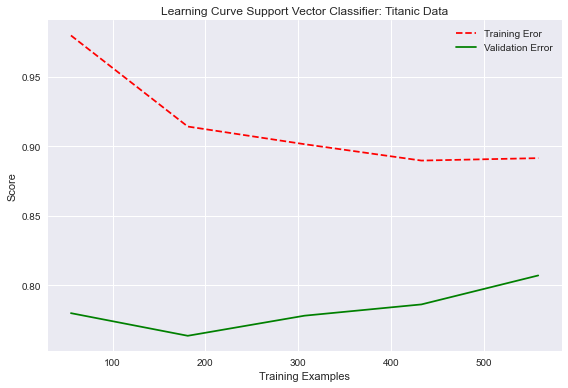

In [35]:
"""plot learning curve"""

train_sizes, train_scores, test_scores = learning_curve(grid_search.best_estimator_, X_train, y_train,cv=10,
                                                            scoring='accuracy')
train_mean =  np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean =  np.mean(test_scores,  axis=1)
test_std = np.std(test_scores, axis=1)

plt.style.use('seaborn')
plt.plot(train_sizes, train_mean, '--', color='red', label='Training Eror')
plt.plot(train_sizes, test_mean, color='green', label='Validation Error')
plt.ylabel('Score')
plt.xlabel('Training Examples')
plt.title('Learning Curve Support Vector Classifier: Titanic Data')
plt.legend()
plt.tight_layout()
plt.show()


Plotting the learning curve for the best support classification model shows that as the training sample size increases the training and validation error begin to converge. Its possible that increasing the number of cv folds for cross validation may improve performance, but could lead to overfitting.